In [ ]:
# !pip install pandas
import pandas as pd
import requests, json

In [ ]:
# Step 1 - Call the API for available language models
import requests
request = requests.get(f"http://cmdb.vectorspacebio.science/api/get_language_models?vxv_wallet_addr=0076e0b8328203a1beb056caf17a05a78929bd74")
language_models = request.json()
print(language_models)

In [ ]:
# Step 2 - Choose a language model - e.g., Biosciences_0001
# Requires code from step 1

language_model = language_models[0]
print(language_model)

In [ ]:
# Step 3 - Define up to 10 custom features / column labels (up to 100,000 labels upon request)
column_labels = ["mena", "opa1", "cardiolipin", "plant"]

In [ ]:
# Step 4 - Optional: Submit a context-dependency - e.g., "mitochondria"
context_dependency = ""
# context_dependency = "mitochondria"

In [95]:
# Step 5 - Call the CMDB API and return a correlation matrix dataset
# This method may take several minutes to complete depending on the request.
# Requires code from step 1-4

# Dependency requirement: pandas
# If using a notebook: %pip install pandas or !pip install pandas
# If using a terminal: pip install pandas

import requests
import pandas as pd

# Specify the types of rows
row_types = "protein_names"
context_dependency = ""

# Retrieve the correlation matrix dataset and hidden relationship matrix
cmd_request = requests.get(f"http://cmdb.vectorspacebio.science/api/get_correlation_matrix?vxv_wallet_addr=0076e0b8328203a1beb056caf17a05a78929bd74&language_model={language_model['name']}&row_types={row_types}&column_labels={'%2C%20'.join(column_labels)}&context_dependency={context_dependency}")

# Retrieve request and convert to dataframes
cm_dataset = pd.DataFrame.from_dict(cmd_request.json())

# Preview the correlation matrix dataset
cm_dataset.head(10)

,mena,opa1,cardiolipin,plant
gpx3,0.176299,0.156379,0.117012,0.087985
klf4,0.212899,0.146064,0.132100,0.098185
lipf,0.149390,0.142724,0.135704,0.106586
serpinh1,0.160110,0.149142,0.126802,0.077069
thy1,0.183890,0.129527,0.124178,0.076974
inhba,0.169712,0.136570,0.109484,0.074945
nup88,0.175310,0.119508,0.102715,0.070485
tp53,0.217818,0.187344,0.151160,0.119801
tenm1,0.164161,0.091425,0.065897,0.053349
edar,0.101486,0.128494,0.086482,0.064477


In [ ]:
# Step 6 - Preprocess the data and output the html heatmap

# This block preprocesses the data, outputs it to the terminal, injects it into a ready-to-go html template and saves the output in json format
# This requires cm_dataset from step 5

data = []

cols = cm_dataset.columns.tolist()
rows = cm_dataset.index.tolist()[:200] # For quick tests limit the number of rows

for col_n, col in enumerate(cols):
    for row_n, row in enumerate(rows):
        data.append([col_n, row_n, cm_dataset[col][row]])

# Visualize the data
print("\nColumn labels:\n")
print(cols)
print("\nRows:\n")
print(rows[:10])
print("\nCorrelation scores (sample):\n")
print(data[:10])

# Load the heatmap template
with open("Heatmap/heatmap-template.html", "r") as file_in:
    text = file_in.read()

# Replace the placeholder text with the data above
text = text.replace("vsb_placeholder_column_labels", str(cols))
text = text.replace("vsb_placeholder_rows", str(rows))
text = text.replace("vsb_placeholder_correlation_scores", str(data))

# Adjust the width, height and legend height of the heatmap
# The more rows included in the heatmap, the larger the height must be for visibility
text = text.replace("vsb_placeholder_heatmap_width", "800")
text = text.replace("vsb_placeholder_heatmap_height", "800")
text = text.replace("vsb_placeholder_heatmap_legend_height", "300")

# Save out the updated heatmap file
with open("Heatmap/heatmap.html", "w") as file_out:
    file_out.write(text)

# Save out the JS
json_output = {"cols": cols, "rows": rows, "correlation_scores": data}
with open("Heatmap/output.json", "w") as file_out:
    json.dump(json_output, file_out)

In [ ]:
# Example of heatmap with rows (of proteins) and column labels

# Dependency requirement: ipython
# If using a notebook: %pip install ipython

from IPython.display import Image
Image(filename='heatmap-example.jpg') 

In [98]:
# Step 7 - Expand the network of relationships by submitting the labels to the Protein-Protein Interaction Network (PPIN) API
# This requires the column_labels from step 3

import requests
import json

# Top_n value of 5 is recommended
top_n = 5

max_depth = 5
scoring_threshold = 0.3
ppin_context_dependency = ""
cross_intersection = False

network_results = []
for column_label in column_labels:
    ppin_request = requests.get(f"http://ppin.vectorspacebio.science/api/protein_network?vxv_wallet_addr=d1030ededff0f348992fd4d41ae169dae99bf9c0&query={column_label}&branches={top_n}&max_depth={max_depth}&min_score={scoring_threshold}&context_dependency={ppin_context_dependency}&cross_intersection={cross_intersection}")
    result = json.loads(ppin_request.content.decode())
    network_results.append(result)

In [99]:
# Step 8 - Preprocess the data and output the html network graph
nodes = []
hidden_relationships = {}

# Add the root node of the graph
root_node = ""
for col in column_labels:
    nodes.append([root_node, col])

# Add the leaf nodes
for result in network_results:
    for item in result["graph_network"]:
        source, target = item["source"], item["target"]
        key = f"{source}_{target}".lower()
        nodes.append([source, target])
        hidden_relationships[key] = item["known_relationship"]

# Visualize the nodes and hidden relationship data
print("\nNodes (sample):\n")
print("'' represents the root node\n")
print(nodes[:10])

print("\nHidden relationships (sample):")
print("1 represents a known relationship, 0 represents a hidden relationship\n")

# Load the network graph template, replace the placeholders with the data above, save out network_graph.html
with open("Network/hidden-relationship-network-template.html", "r") as file_in:
    text = file_in.read()

text = text.replace("vsb_placeholder_nodes", str(nodes))
text = text.replace("vsb_placeholder_hidden_relationships", str(hidden_relationships))

with open("Network/hidden-relationship-network.html", "w") as file_out:
    file_out.write(text)

# Save out the JS
json_output = {"nodes": nodes, "hidden_relationships": hidden_relationships}
with open("Network/output.json", "w") as file_out:
    json.dump(json_output, file_out)


Nodes (sample):

'' represents the root node

[['', 'mena'], ['', 'opa1'], ['', 'cardiolipin'], ['', 'plant'], ['mena', 'Q8N8S7'], ['mena', 'Q7Z6K5'], ['mena', 'P35080'], ['mena', 'Q9UHD8'], ['mena', 'P11171'], ['Q8N8S7', 'Q9UI08']]

Hidden relationships (sample):
1 represents a known relationship, 0 represents a hidden relationship



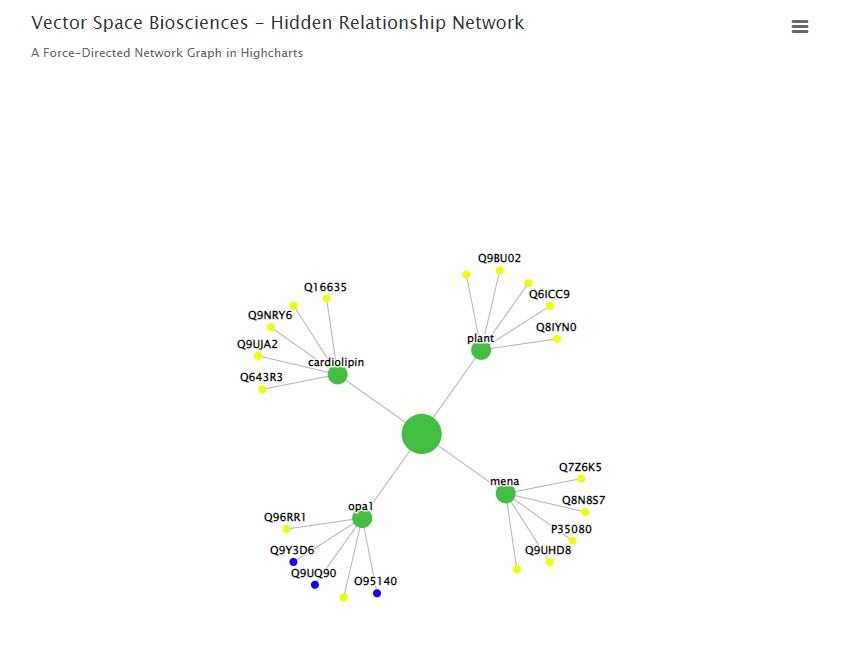

In [96]:
# Example of heatmap with rows (of proteins) and column labels

# Dependency requirement: ipython
# If using a notebook: %pip install ipython

from IPython.display import Image
Image(filename='hidden-relationship-network-example.jpg') 